# `20200421b` - testing the A-Law

In [1]:
import numpy as np
import matplotlib 
import math
import matplotlib.pyplot as plt

from scipy.signal import hilbert
#/home/kelu/ultrasound/echomods/matty/LawA/20191027b-1.npz
#/home/kelu/ultrasound/echomods/matty/LawA/20200112a-1.npz
#/home/kelu/ultrasound/echomods/matty/LawA/20200418a-4-env.npz
#/home/kelu/ultrasound/echomods/matty/LawA/20200418a-4-raw.npz

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
t = [ x / 64 for x in range(128*64)]

In [3]:
uA = np.load("20191027b-1.npz")
img = np.load("20200418a-4-env.npz")["a"]

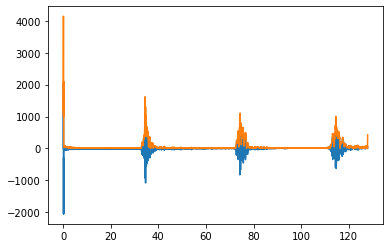

In [4]:
tmp = uA["a"]-1024-512
plt.plot(t,tmp)
plt.plot(t,np.abs(hilbert(tmp)))
plt.show()

In [5]:
def lawAcompress(signal):
    compressed = []
    for k in signal:
        compressed.append(applyLaw(k))
    return compressed

def applyLaw(n):
    val = -1
    for k in range(7):
        if n >> (11-k):
            val = 1 
            reste = n - 2**(11-k)
            mantisse = bin(int(bin(reste)[:7],2))
            resultat = (7-k)*(2**5) + int(mantisse,2)
            #print(bin(n),val,k,  mantisse, bin(resultat),resultat ) 
            return int(resultat)
    resultat = int(bin(n)[:7],2)
    #print(bin(n),bin(resultat)) 
    return int(resultat)

print(applyLaw(1))

1


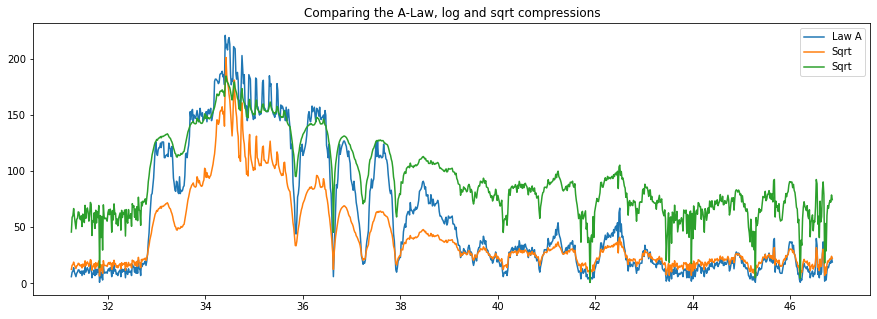

In [11]:
lawA = lawAcompress(np.abs(uA["a"]-1024-512))
lawA_h = lawAcompress(np.abs(hilbert(tmp)).astype(int))

#plt.plot(lawA[2000:3000])
plt.figure(figsize=(15,5))
plt.plot(t[2000:3000],np.array(lawA_h).astype(int)[2000:3000],label="Law A")
plt.plot(t[2000:3000],5.0*np.sqrt(np.abs(hilbert(tmp)))[2000:3000],label="Sqrt")
plt.plot(t[2000:3000],25.0*np.log(np.abs(hilbert(tmp)))[2000:3000],label="Sqrt")
plt.title("Comparing the A-Law, log and sqrt compressions")
plt.legend()
plt.show()

# `20240415a` producing 8bit signal for DDS test

1.0 256.0
0 255


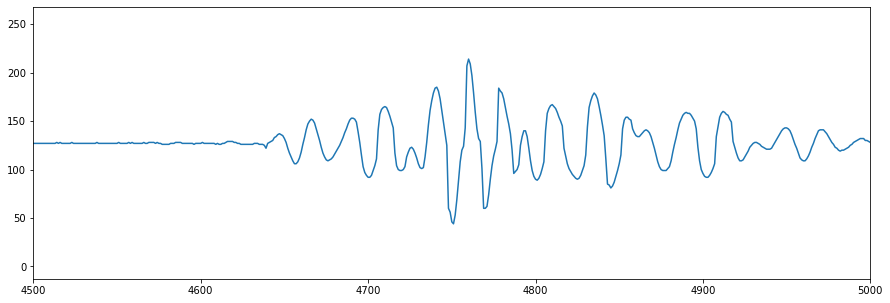

In [130]:
sig = uA["a"]-1024-512
for x in range(1024+512):
    sig[x] = 0
M = np.max(np.abs(sig))
sig = sig*128/M+128
DEC = 2
OFFSET = 128
for x in range(2**7):
    for k in range(DEC):
        sig[OFFSET+x*DEC+k] =  128+x

OFFSET = 2**7*DEC + 2*OFFSET
for x in range(2**7):
    for k in range(DEC):
        sig[OFFSET+x*DEC+k] =  128-x

OFFSET = OFFSET + 2**7*DEC + 40
DEC = 8
for x in range(2**4):
    for k in range(DEC):
        if (k//4)%2:
            sig[OFFSET+x*DEC+k] =  128-8*x
        else:
            sig[OFFSET+x*DEC+k] =  128+8*x
OFFSET = 720+150+100
DEC = 4
for x in range(2**4):
    for k in range(DEC):
        if (k//2)%2:
            sig[OFFSET+x*DEC+k] =  128-8*x
        else:
            sig[OFFSET+x*DEC+k] =  128+8*x


for x in range(100):
    sig[-x] = 128
for st in [-1,1]:
    sig[st*1] = 1
    sig[st*2] = 255
    sig[st*3] = 255
    sig[st*4] = 1
    sig[st*5] = 1
    sig[st*6] = 1
    sig[st*7] = 255

print(np.min(sig),np.max(sig))
if np.min(sig) ==1:
    sig = sig-1

assert np.max(sig) < 256

sig = [int(x) for x in sig]
print(np.min(sig),np.max(sig))
plt.figure(figsize=(15,5))
plt.plot(sig)
plt.xlim((4500,5000))
np.array(sig).tofile('data.csv',sep=',')

### Producing a summary

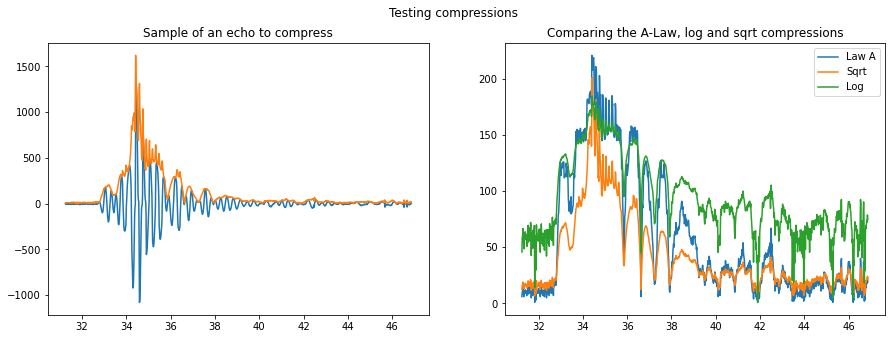

In [7]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(t[2000:3000],tmp[2000:3000])
ax1.plot(t[2000:3000],np.abs(hilbert(tmp))[2000:3000])

ax1.set_title('Sample of an echo to compress')
ax2.plot(t[2000:3000],np.array(lawA_h).astype(int)[2000:3000],label="Law A")
ax2.plot(t[2000:3000],5.0*np.sqrt(np.abs(hilbert(tmp)))[2000:3000],label="Sqrt")
ax2.plot(t[2000:3000],25.0*np.log(np.abs(hilbert(tmp)))[2000:3000],label="Log")
ax2.set_title("Comparing the A-Law, log and sqrt compressions")
ax2.legend()
f.suptitle("Testing compressions");
f.savefig("comparison.jpg")

# Let's play on a 2D image

In [8]:
from scipy import ndimage, signal 

In [9]:
compressed = []
for line in img:
    lawA = lawAcompress(np.array(352.0*line).astype(int))
    compressed.append(lawA)

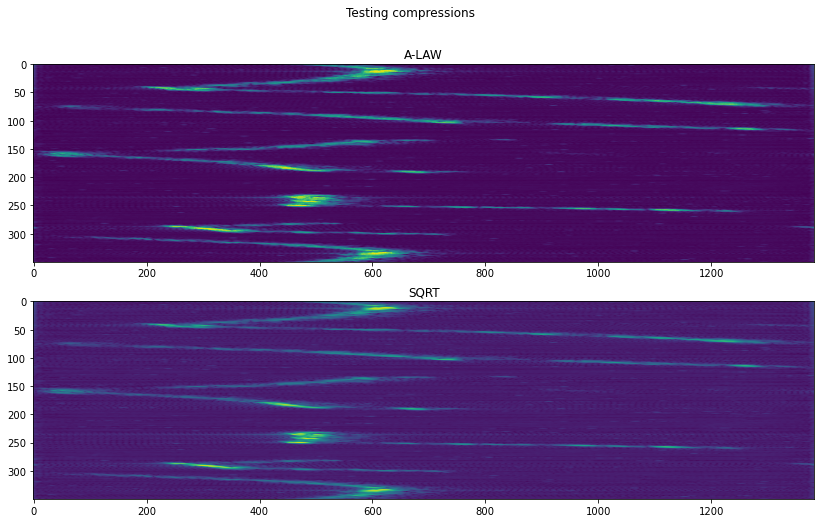

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,8))
ax1.imshow(compressed)
ax1.set_title('A-LAW')

ax2.imshow(np.sqrt(img))
ax2.set_title('SQRT')

f.suptitle("Testing compressions");
f.savefig("2d_comparison.jpg")